In [1]:
from transformers import BitsAndBytesConfig, AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [2]:
model_name = "t5-small-no-tokenizer-separated20000"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
def inference_4bit(tokenizer, text, model_name, num_return_sequences=1, num_beams=10):
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype="float16",
    )

    model_4bit = AutoModelForSeq2SeqLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
    ).to("cuda")

    inputs = tokenizer(text, return_tensors="pt", return_token_type_ids=False).to(model_4bit.device)
    outputs = model_4bit.generate(
        **inputs, 
        max_length=256, 
        repetition_penalty=1.0, 
        do_sample=False, 
        num_return_sequences=num_return_sequences, 
        num_beams=num_beams, 
        output_scores=True, 
        return_dict_in_generate=True
    )

    preds_4bit = tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)
    return preds_4bit[0]

def inference_8bit(tokenizer, text, model_name, num_return_sequences=1, num_beams=10):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
    )

    model_8bit = AutoModelForSeq2SeqLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
    )

    inputs = tokenizer(text, return_tensors="pt", return_token_type_ids=False).to(model_8bit.device)
    outputs = model_8bit.generate(
        **inputs, 
        max_length=256, 
        repetition_penalty=1.0, 
        do_sample=False, 
        num_return_sequences=num_return_sequences, 
        num_beams=num_beams, 
        output_scores=True, 
        return_dict_in_generate=True
    )

    preds_8bit = tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)
    return preds_8bit[0]

def inference_fp16(tokenizer, text, model_name, num_return_sequences=1, num_beams=10):
    model_fp16 = AutoModelForSeq2SeqLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
    ).to("cuda")

    inputs = tokenizer(text, return_tensors="pt", return_token_type_ids=False).to(model_fp16.device)
    outputs = model_fp16.generate(
        **inputs, 
        max_length=256, 
        repetition_penalty=1.0, 
        do_sample=False, 
        num_return_sequences=num_return_sequences, 
        num_beams=num_beams, 
        output_scores=True, 
        return_dict_in_generate=True
    )

    preds_fp16 = tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)
    return preds_fp16[0]

def inference_fp32(tokenizer, text, model_name, num_return_sequences=1, num_beams=10):
    model_fp32 = AutoModelForSeq2SeqLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32,
        device_map="auto",
    ).to("cuda")

    inputs = tokenizer(text, return_tensors="pt", return_token_type_ids=False).to(model_fp32.device)
    outputs = model_fp32.generate(
        **inputs, 
        max_length=256, 
        repetition_penalty=1.0, 
        do_sample=False, 
        num_return_sequences=num_return_sequences, 
        num_beams=num_beams, 
        output_scores=True, 
        return_dict_in_generate=True
    )

    preds_fp32 = tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)
    return preds_fp32[0]

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw

In [13]:
text = "CC(=O)[O-].CC(=O)[O-].CC(C)(C)[O-].CN(C)C1CCNC1.COc1cccc(-c2c(C)c(C#N)c3nc(C(C)(C)C)oc3c2Br)c1.Cc1ccccc1.O.O=C([O-])O.[Na+].[Na+].[Pd+2],COc1cccc(-c2c(C)c(C#N)c3nc(C(C)(C)C)oc3c2N2CCC(N(C)C)C2)c1"
text_list = text.split(",")

inp = text_list[0]
ground_truth = text_list[1]

inp, ground_truth

('CC(=O)[O-].CC(=O)[O-].CC(C)(C)[O-].CN(C)C1CCNC1.COc1cccc(-c2c(C)c(C#N)c3nc(C(C)(C)C)oc3c2Br)c1.Cc1ccccc1.O.O=C([O-])O.[Na+].[Na+].[Pd+2]',
 'COc1cccc(-c2c(C)c(C#N)c3nc(C(C)(C)C)oc3c2N2CCC(N(C)C)C2)c1')

Reactants

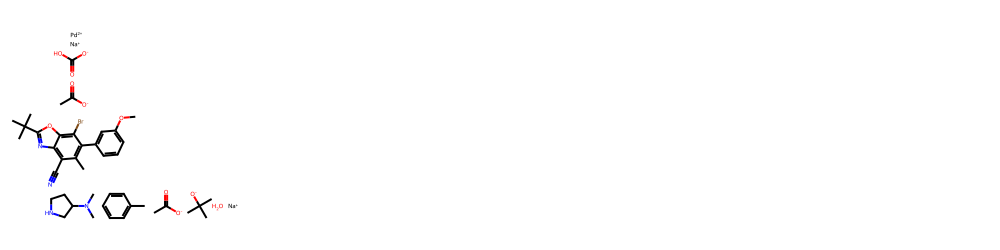

In [14]:
mol_inps = inp.split(">")
mols = [Chem.MolFromSmiles(s) for s in mol_inps]

img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=4,
    subImgSize=(250,250)
)
img

Products ground truth

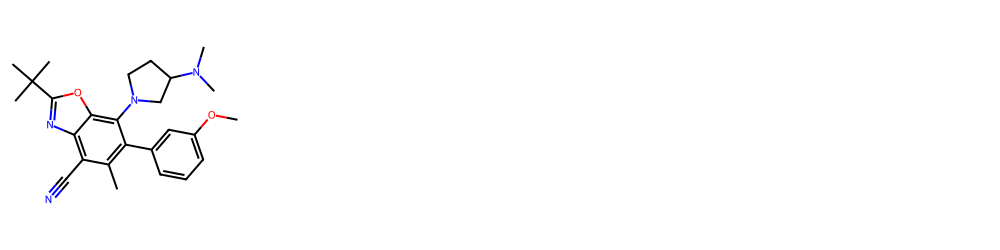

In [15]:
mol_ground_truths = ground_truth.split(">")
mols = [Chem.MolFromSmiles(s) for s in mol_ground_truths]

img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=4,
    subImgSize=(250,250)
)
img

Predictions

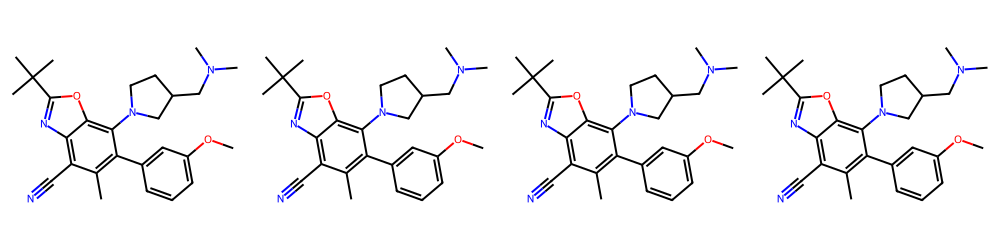

In [16]:
mol_4bit = inference_4bit(tokenizer, inp, model_name)
mol_8bit = inference_8bit(tokenizer, inp, model_name)
mol_fp16 = inference_fp16(tokenizer, inp, model_name)
mol_fp32 = inference_fp32(tokenizer, inp, model_name)

smiles = [mol_4bit, mol_8bit, mol_fp16, mol_fp32]
mols = [Chem.MolFromSmiles(s) for s in smiles]

img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=4,
    subImgSize=(250,250)
)
img